In [97]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [98]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [99]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [100]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [101]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [102]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [103]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [104]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [141]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

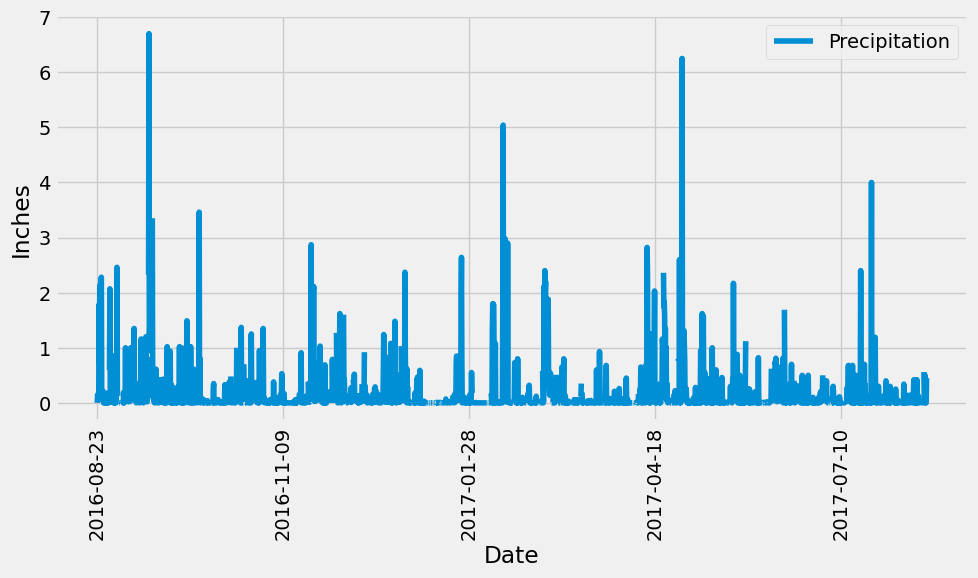

In [106]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert to datetime
if isinstance(most_recent_date, str):
    most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year before the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago.strftime('%Y-%m-%d')).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', kind='line', figsize=(10, 6), linestyle='-')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [107]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [139]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).scalar()

# Print the result
total_stations

9

In [109]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations
active_stations = session.query(
    measurement.station,
    func.count(measurement.station).label('count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

# Print the stations and their counts
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [126]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Subquery to find the most active station (station with the most rows)
most_active_station_subquery = session.query(
    measurement.station
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).limit(1).subquery()

# Main query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active_station_subquery.c.station).one()

# Extract the results
min_temp, max_temp, avg_temp = temperature_stats

temperature_stats


(54.0, 85.0, 71.66378066378067)

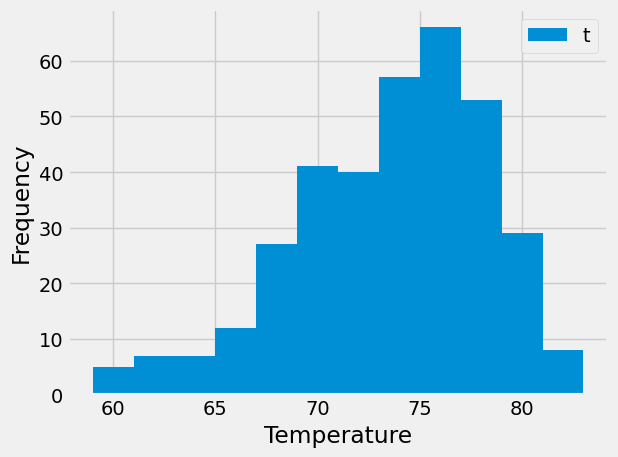

In [135]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year before the most recent date in the dataset
most_recent_date = session.query(func.max(measurement.date)).scalar()
if isinstance(most_recent_date, str):
    most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()

# Convert the query results to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend('tobs')
plt.tight_layout()

# Show the plot
plt.show()

# Close Session

In [112]:
# Close Session
session.close()